In [11]:
%matplotlib inline

In [12]:
# %matplotlib notebook
import matplotlib as mpl
mpl.use('Agg')
# mpl.rcParams.update({'font.size': 26})

import os
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from itertools import product, takewhile
from collections import defaultdict
from plot_utils import richify_line_style
from plot_utils import make_line_cycle
line_cycle = make_line_cycle()

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [13]:
from cycler import cycler
plt.rc('axes',
       prop_cycle=(
           cycler('color', ['b', 'g', 'r', 'y', 'g', 'b']) +
           cycler('linestyle', ['-', '-', '-', '-', '--', '-']) +
           cycler('marker', ['', '', '', '', 'o', '*'])
       ))

In [14]:
from plot_utils import make_line_cycle
line_cycle = make_line_cycle()

In [15]:
def plot_performance(datasets, models, methods, qs, qs_str, column_names, savefig=False, savelegend=False):
    dirname_template = "outputs/paper_experiment/{dataset}/{model}/{method}/qs/{q}.pkl"
    result = {}
    for dataset, model in product(datasets, models):
        key = (dataset, model)
        result[key] = {}
        for method in methods:
            result[key][method] = []
            for q in qs_str:
                path = dirname_template.format(dataset=dataset, model=model, method=method, q=q)
                try:
                    result[key][method].append(pd.read_pickle(path))
                except FileNotFoundError:
                    print('{} not found'.format(path))
                    dummy = defaultdict(lambda :defaultdict(lambda: None))
                    result[key][method].append(dummy)

    nrow = (len(datasets) if len(datasets) > 1 else len(models))
    per_width, per_height, ncol = 3, 2.2, len(column_names)
    for i, (dataset, model) in enumerate(product(datasets, models)):
        key = (dataset, model)
        # one plot
        for j, column in enumerate(column_names):
            if i == 0:
                lines = []
            idx = i * ncol + j + 1
            fig = plt.figure(figsize=(per_width, per_height))
            ax = fig.add_subplot(111)
            for method in methods:
                # one legend
                try:
                    ys = [df[column]['mean'] for df in result[key][method]]                
                except KeyError:
                    print(dataset, method, model)
                    raise KeyError
                lst = list(zip(*takewhile(lambda tpl: tpl[1] is not None, zip(qs, ys))))
                if lst:
                    correct_qs, correct_ys = lst
                    # l, = ax.semilogx(correct_qs, correct_ys, markersize=7.5, alpha=0.75, basex=2)
                    l, = ax.plot(correct_qs, correct_ys, next(line_cycle), markersize=7.5, alpha=0.75)
                    if i == 0:
                        lines.append(l)
                else:
                    continue        
            # ax.set_title(column)
            column_map = {'n.prec': 'precision', 'n.rec': 'recall', 'cos-sim': 'cosine sim',
                          'e.prec': 'e.precision', 'e.rec': 'e.recall',
                          'obj': '|edges|', 'rank-corr': 'order corr'}
            ax.set_ylabel(column_map.get(column, column))            
            ax.set_xlabel('prop. of reports')
            
            max_yticks = 4
            ax.yaxis.set_major_locator(plt.MaxNLocator(max_yticks))
            ax.xaxis.set_major_locator(plt.MaxNLocator(max_yticks))

            # ylim = (0, 1)
            ylim = None
            if column in {"n.prec"}:
                ylim  = (0.5, 1.1)
            if column in {'obj'}:
                ylim = None
                
            if ylim is not None:
                ax.set_ylim(*ylim)

            xticks = ax.get_xticks()
            labels = list(map(lambda v: "$2^{}$".format(int(v)), xticks))
            ax.set_xticklabels(labels)

            if column == 'obj':
                yticks = ax.get_yticks()
                if yticks.max() > 100:
                    ax.set_yticklabels(list(map(lambda v: "{:.1f}k".format(v / 1000), yticks)))
            fig.tight_layout()

            label_y_pos = 0.96
            title_fontsize=12
            dirname = 'figs/paper_experiment/'
            if len(datasets) > 1:
                dirname += '{}-by_datasets/'.format(models[0])
                path = dirname + '{}-{}.pdf'.format(dataset, column_map.get(column, column).replace('|', '').replace(' ', '-'))
                ax.set_title(dataset, y=label_y_pos, fontsize=title_fontsize)
            else:
                dirname += '{}_by_models/'.format(datasets[0])
                path = dirname + '{}-{}.pdf'.format(model, column_map.get(column, column).replace('|', '').replace(' ', '-'))
                ax.set_title(model.upper(), y=label_y_pos, fontsize=title_fontsize)

            ax.text(0.005, 0.21, r"$0.001\times$ ", transform=plt.gcf().transFigure)
            if not os.path.exists(dirname):
                os.makedirs(dirname)
            if savefig:
                fig.savefig(path)

    figlegend = plt.figure(figsize=(2.2 * len(methods), 0.5))
    ax = fig.add_subplot(111)

    name_mapping = {'no-order': 'steiner', 'closure': 'closure', 'tbfs': 'delayed-bfs', 'greedy': 'greedy'}
    legends = list(map(lambda m: name_mapping[m], methods))

    figlegend.legend(lines, legends, 'center', ncol=len(legends), fontsize=18)
    fig.show()
    figlegend.show()
    
    if savelegend:
        figlegend.savefig(dirname + 'legend.pdf')
    return result

['0.001', '0.002', '0.004', '0.008', '0.016', '0.032', '0.064', '0.128', '0.256']


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


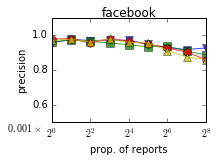

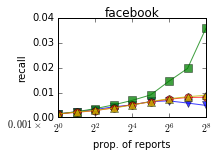

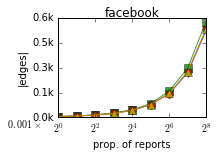

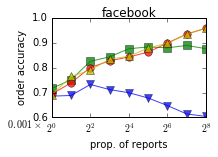

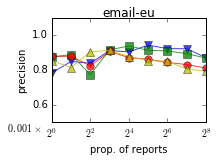

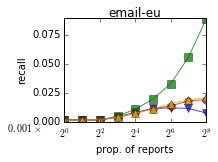

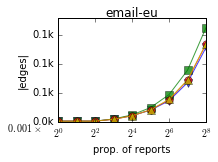

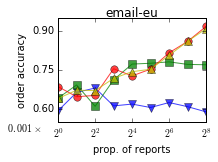

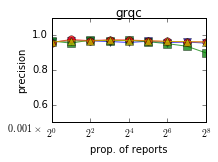

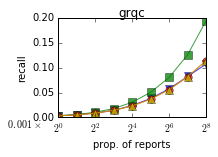

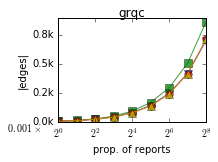

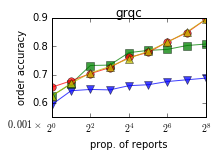

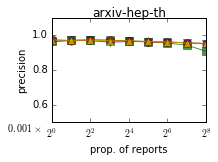

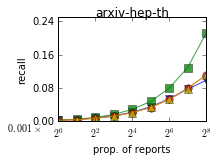

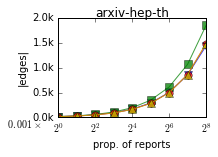

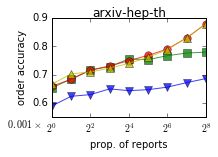

In [16]:
datasets = ['facebook', 'email-eu', 'grqc', 'arxiv-hep-th']
# datasets = ['email-eu']
# datasets = ['grqc']
# datasets = ['arxiv-hep-th']
# datasets = ['facebook']
# models = ['si', 'ct', 'sp', 'ic']
# 'si', 'ic', 'ct
# models = ['si']
models = ['ct']

methods = ["no-order", "tbfs", "greedy", "closure"] 

qs = np.array([0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256])
qs_str = list(map(str, qs))

qs /= qs[0]
qs = np.asarray(np.log2(qs), dtype=np.int64)

print(qs_str)
column_names = []
column_names += ['n.prec']
column_names += ['n.rec']
column_names += ['obj']
# column_names += ['e.prec']
# column_names += ['e.rec']
column_names += ['order accuracy']

assert column_names
result = plot_performance(datasets, models, methods, qs, qs_str, column_names, savefig=True, savelegend=True)